Upload the file containing the processed ASB data (Processed_ASB_data.csv) This can be done from the files menu.

In [1]:
!pip install tensorflow==2.13.1

In [3]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
!pip install keras-tuner -q
import keras_tuner
#!pip install tensorflow==2.13.0. # model import wont work with tf==2.14.0
import tensorflow
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix
from tensorflow import keras
#from google.colab import files
import pandas as pd
from sklearn.model_selection import RepeatedKFold, cross_val_score, StratifiedKFold
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold
#!pip install -q -U keras-tuner
#import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#uploades = files.upload()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


Saving the processed data to feature arrays and labels

In [4]:
AdAstradataset = np.genfromtxt("Processed_ASB_data.csv",delimiter=',', dtype=None, names=("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","change","RO1","RO2","RO3","RO4","RO5","RO6","RO7","RO8","MO1","MO2","MO3","MO4","MO5","MO6","MO7","MO8","class","WildP","MutP","Identifier"))
AdAstraarray = np.array(AdAstradataset.tolist())
AdAstraY = AdAstraarray[:,47]
AdAstraX = np.concatenate((AdAstraarray[:, 0:47], AdAstraarray[:, 48:50]), axis=1)
AdAstraX = AdAstraX.astype(float)
AdAstraY = AdAstraY.astype(str)
AdAstraY, AdAstray = np.unique(AdAstraY, return_inverse=True)
AdAstray = keras.utils.to_categorical(AdAstray, num_classes=3)
y = AdAstray
X = AdAstraX
AdAstrId = AdAstraarray[:,50]

<ipython-input-4-dc1f48a1db97>:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  AdAstradataset = np.genfromtxt("Processed_ASB_data.csv",delimiter=',', dtype=None, names=("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","change","RO1","RO2","RO3","RO4","RO5","RO6","RO7","RO8","MO1","MO2","MO3","MO4","MO5","MO6","MO7","MO8","class","WildP","MutP","Identifier"))


Splitting the data into train, validation and testing

In [5]:
from sklearn.utils import resample

# Convert the one-hot encoded `y` to class labels (1, 2, or 3)
y_labels = np.argmax(y, axis=1) + 1  # +1 to shift from 0-indexed to 1-indexed classes

# Get the indices of each class
class_1_indices = np.where(y_labels == 1)[0]
class_2_indices = np.where(y_labels == 2)[0]
class_3_indices = np.where(y_labels == 3)[0]

# Find the minimum number of samples among the classes (to balance)
min_class_count = min(len(class_1_indices), len(class_2_indices), len(class_3_indices))



# Shuffle and select 70% of the smallest class count for each class (balanced classes for training)
train_class_1_indices = resample(class_1_indices, replace=False, n_samples=int(min_class_count * 0.7), random_state=42)
train_class_2_indices = resample(class_2_indices, replace=False, n_samples=int(min_class_count * 0.7), random_state=42)
train_class_3_indices = resample(class_3_indices, replace=False, n_samples=int(min_class_count * 0.7), random_state=42)

# Combine the training indices from each class
train_indices = np.concatenate([train_class_1_indices, train_class_2_indices, train_class_3_indices])

# Create the training sets
x_train = X[train_indices]
y_train = y[train_indices]
AdAstrId_train = AdAstrId[train_indices]

# The remaining indices are used for the testing set
test_class_1_indices = np.setdiff1d(class_1_indices, train_class_1_indices)
test_class_2_indices = np.setdiff1d(class_2_indices, train_class_2_indices)
test_class_3_indices = np.setdiff1d(class_3_indices, train_class_3_indices)

# Combine the remaining indices from each class
test_indices = np.concatenate([test_class_1_indices, test_class_2_indices, test_class_3_indices])

# Create the testing sets
x_test = X[test_indices]
y_test = y[test_indices]
AdAstrId_test = AdAstrId[test_indices]


Checking for the number of each classification in the test data set

In [6]:
classifications = np.argmax(y_test, axis=1) + 1  # +1 to make it 1-based indexing
unique, counts = np.unique(classifications, return_counts=True)
for cls, count in zip(unique, counts):
    print(f'Classification {cls}: {count} occurrences')

Classification 1: 1269 occurrences
Classification 2: 2028 occurrences
Classification 3: 6037 occurrences


Now creating the validation set

In [10]:
from keras import layers
import math
from sklearn.model_selection import train_test_split

x_test, x_val, y_test, y_val, AdAstrId_test, AdAstrId_test_val = train_test_split(x_test, y_test, AdAstrId_test, test_size=0.1,random_state=42)


In our processed ASB data we have windowed and non windowed scores here we grab the windowed scores.

In [11]:
Windowed_train = []
#NonWindowed_train = []
for i in x_train:
  Windowed_train.append(np.concatenate([i[:30], i[47:49]]).reshape((8, -1)))
  #NonWindowed_train.append(i[31:].reshape((4,-1)))

Windowed_train = np.array(Windowed_train)
#NonWindowed_train = np.array(NonWindowed_train)

Windowed_test = []
#NonWindowed_test = []
for i in x_test:
  Windowed_test.append(np.concatenate([i[:30], i[47:49]]).reshape((8, -1)))
  #NonWindowed_test.append(i[31:].reshape((4,-1)))


Windowed_test = np.array(Windowed_test)
#NonWindowed_test = np.array(NonWindowed_test)

Windowed_val = []
#NonWindowed_val = []
for i in x_val:
  Windowed_val.append(np.concatenate([i[:30], i[47:49]]).reshape((8, -1)))
  #NonWindowed_val.append(i[31:].reshape((4,-1)))


Windowed_val = np.array(Windowed_val)
#NonWindowed_val = np.array(NonWindowed_val)





An overview of the data that has ben subdivided

In [12]:
print(Windowed_val.shape)
print(y_val.shape)
print(Windowed_test.shape)
print(y_test.shape)
print(Windowed_train.shape)
print(y_train.shape)


(934, 8, 4)
(934, 3)
(8400, 8, 4)
(8400, 3)
(8877, 8, 4)
(8877, 3)


Setting the class weight. Since our training data is balanced the weights will be balanced as well. (this step is left in to allow for additional data to be included)

In [13]:

class_weight = {0: list(y_train.argmax(axis=-1)).count(0),
                1: list(y_train.argmax(axis=-1)).count(1),
                2: list(y_train.argmax(axis=-1)).count(2)}

maxWeight = max(class_weight.values())

class_weight[0] = maxWeight/class_weight[0]
class_weight[1] = maxWeight/class_weight[1]
class_weight[2] = maxWeight/class_weight[2]



Training A CNN without hyperparameter tuning

In [14]:

model2 = keras.models.Sequential()

model2.add(layers.Conv2D(4,(2,2), strides = 1 , padding = "same", activation = "relu", input_shape = (8,4,1)))
model2.add(layers.Conv2D(4,(2,2), strides = 1, padding = "same", activation = "relu"))
model2.add(layers.MaxPool2D(pool_size=(2,1)))
model2.add(layers.Conv2D(48,(2,2), padding = "same", activation = "relu"))
model2.add(layers.Conv2D(96,(2,2), padding = "same", activation = "relu"))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64,activation="relu"))
model2.add(layers.Dense(3,activation='softmax'))
print(model2.summary())


loss = keras.losses.categorical_crossentropy
optim = keras.optimizers.Adam(learning_rate=0.001)
#metrics = ["accuracy"]
metrics = [keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'), keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc') ]

model2.compile(optimizer=optim, loss=loss, metrics=metrics)

batch_size = 64
epochs = 40

history2 = model2.fit(Windowed_train, y_train,  validation_data=(Windowed_val, y_val), shuffle=True, epochs=epochs,batch_size=batch_size, verbose=2, class_weight=class_weight)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 4, 4)           20        
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 4)           68        
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 4)           0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 48)          816       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 96)          18528     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 96)          0         
 g2D)                                                 

We will now train another model, this time we are going to use keras tuner to optimize our hyperparameters

In [15]:
import keras_tuner as kt
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau


# Define a model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # Convolutional layers with tunable parameters
    model.add(layers.Conv2D(hp.Int('filters_1', min_value=4, max_value=32, step=4),(2,2), strides = 1 , padding = "same", activation = "relu", input_shape = (8,4,1), kernel_regularizer=l2(0.001)))
    model.add(layers.Conv2D(hp.Int('filters_2', min_value=4, max_value=64, step=4),(2,2), strides = 1, padding = "same", activation = "relu", kernel_regularizer=l2(0.001)))
    model.add(layers.MaxPool2D(pool_size=(2,1)))
    model.add(layers.Conv2D(hp.Int('filters_3', min_value=16, max_value=128, step=16),(2,2), padding = "same", activation = "relu", kernel_regularizer=l2(0.001)))
    model.add(layers.Conv2D(hp.Int('filters_4', min_value=32, max_value=256, step=32),(2,2), padding = "same", activation = "relu", kernel_regularizer=l2(0.001)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())


    # Dense layer with tunable units
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

# Create the tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='my_dir', project_name='CNN_tuning')

# Run the tuner search
tuner.search(Windowed_train, y_train, epochs=10, validation_data=(Windowed_val, y_val), class_weight=class_weight)


Trial 30 Complete [00h 00m 31s]
val_accuracy: 0.8443968296051025

Best val_accuracy So Far: 0.8479657173156738
Total elapsed time: 00h 10m 45s


Now the best model is selected.

In [16]:

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'),
             keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
)


Using the hyperparameters from our best run we now train a new model

In [17]:
history = best_model.fit(
    Windowed_train, y_train,
    validation_data=(Windowed_val, y_val),
    epochs=40,  # You can increase the number of epochs for a full training
    batch_size=64,  # Keep the batch size as per your previous setup or modify
    shuffle=True,
    class_weight=class_weight  # If using class weights
)

Epoch 1/40
139/139 [==============================] - 5s 18ms/step - loss: 0.9926 - tp: 4565.0000 - fp: 2083.0000 - tn: 15671.0000 - fn: 4312.0000 - accuracy: 0.7599 - precision: 0.6867 - recall: 0.5143 - auc: 0.7919 - val_loss: 1.1775 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1868.0000 - val_fn: 934.0000 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7657
Epoch 2/40
139/139 [==============================] - 2s 14ms/step - loss: 0.9171 - tp: 4875.0000 - fp: 2060.0000 - tn: 15694.0000 - fn: 4002.0000 - accuracy: 0.7724 - precision: 0.7030 - recall: 0.5492 - auc: 0.8111 - val_loss: 1.0901 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 1868.0000 - val_fn: 933.0000 - val_accuracy: 0.6670 - val_precision: 1.0000 - val_recall: 0.0011 - val_auc: 0.8289
Epoch 3/40
139/139 [==============================] - 2s 18ms/step - loss: 0.8908 - tp: 4959.0000 - fp: 1989.0000 - tn: 15765.0000 - fn: 3918.0000 - accuracy: 0.7782 - precision: 0.7137 - re

Here we can view the progress of loss and accuracy accross the training and validation data sets

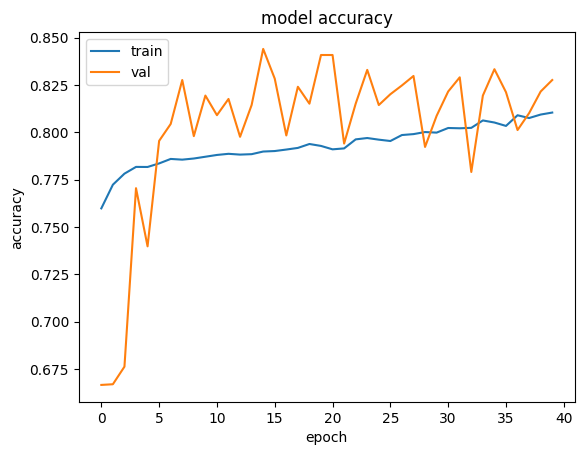

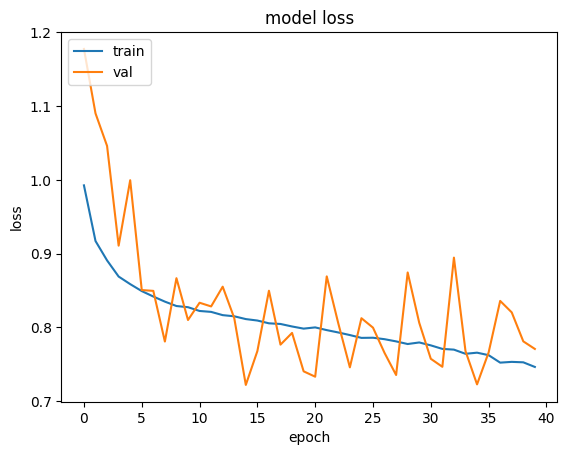

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Now we make predictions on the testing data set with our optimized CNN

263/263 [==============================] - 2s 6ms/step


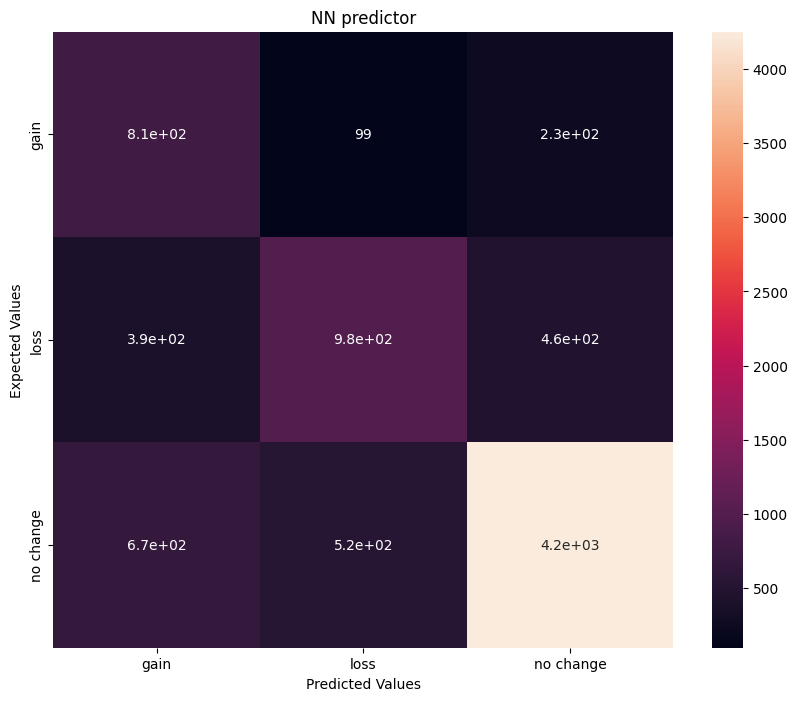

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(y_test.argmax(axis=-1), best_model.predict(Windowed_test).argmax(axis=-1))#hypermodel.predict(x_test).argmax(axis=-1))
#cm = confusion_matrix(list(Test_labelsy.argmax(axis=-1)), y_pred_list)
cm_df = pd.DataFrame(cm,
                     index = ['gain','loss','no change'],
                     columns = ['gain','loss','no change'])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('NN predictor')
plt.ylabel('Expected Values')
plt.xlabel('Predicted Values')
plt.show()


To view the exact numbers for each we can print out the confusion matrix in a simple format

In [20]:
cm

array([[ 810,   99,  231],
       [ 391,  975,  456],
       [ 667,  521, 4250]])

We can measure the performance of the model along several metrics

In [21]:
result = best_model.evaluate(Windowed_test, y_test, batch_size=batch_size, verbose=2)

132/132 - 1s - loss: 0.8159 - tp: 5188.0000 - fp: 1608.0000 - tn: 15192.0000 - fn: 3212.0000 - accuracy: 0.8087 - precision: 0.7634 - recall: 0.6176 - auc: 0.8409 - 1s/epoch - 9ms/step


We can look at a few more metrics

In [22]:
tp = result[1]
fp = result[2]
tn = result[3]
fn = result[4]

TPR = tp/(tp+fn)
Precision = tp/(tp+fp)
FPR = fp/(fp+tn)
accuracy = (tp+tn)/(tp+fp+tn+fn)
fscore = (tp*2)/(tp*2+fp+fn)


print("TPR:", TPR, "\nFPR:", FPR, "\nPrecision:", Precision, "\naccuracy:", accuracy,"\nfscore:", fscore)



TPR: 0.6176190476190476 
FPR: 0.09571428571428571 
Precision: 0.7633902295467923 
accuracy: 0.8087301587301587 
fscore: 0.6828112661226639


We can plot the ROC curves for our model

263/263 [==============================] - 2s 7ms/step


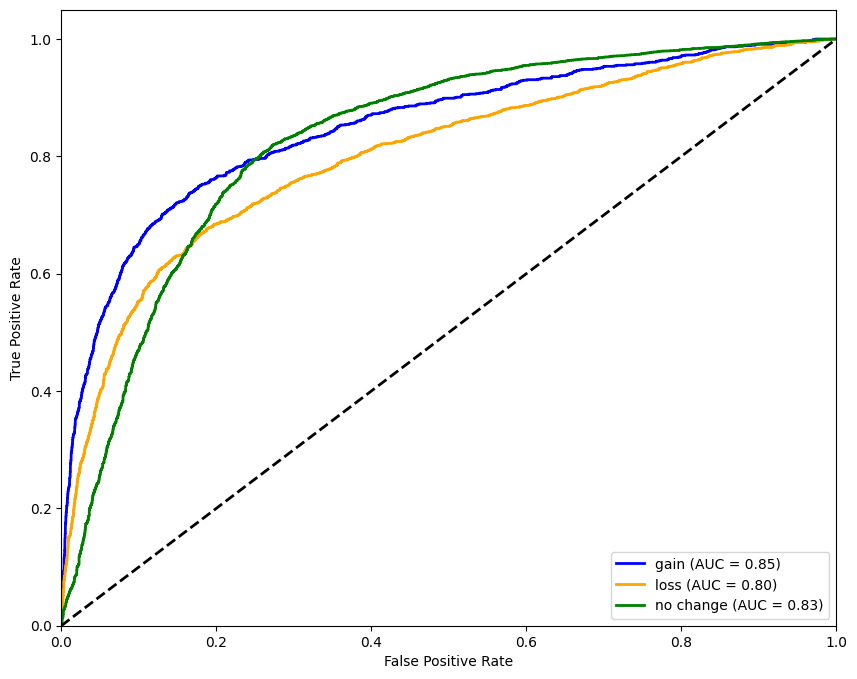

In [23]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming you have the classes 'gain', 'loss', and 'no change'
n_classes = 3  # number of classes

# Binarize the true labels (y_test) for multi-class ROC
y_test_binarized = label_binarize(y_test.argmax(axis=-1), classes=[0, 1, 2])

# Get the model predictions in probabilities (assuming softmax output)
y_score = best_model.predict(Windowed_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves for each class
plt.figure(figsize=(10, 8))

classname = ["gain","loss","no change"]
colors = ['blue', 'orange', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classname[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The newly trained CNN can be saved and downloaded (uncomment the lines to do so)

In [24]:
from google.colab import files
#best_model.save("Newly_trained_CNN.keras")
#files.download("Newly_trained_CNN.keras")

We have saved the ids for all of the test data in the AdAstrId_test variable

In [25]:
AdAstrId_test

array([b' chr10-99393234-G-A-runx3', b' chr10-112563183-T-A-runx3',
       b' chr14-35761592-G-A-max', ..., b' chr1-11797186-T-C-jund',
       b' chr7-80941580-G-C-PPARG', b' chr11-6634237-A-G-rfx5'],
      dtype='|S32')

Remember that the CNN trained in this manner forms the backbone of SNPeBoT, but that the predictions within SNPeBoT include a post-hoc filter with various thresholds. In order to test the data on SNPeBoT the test ids can be downloaded and used in conjuction with the ASB_sequences.tsv file. Labels follow the format of (chromosome-position-reference_allele-alternate_allele-Transcription_Factor) these can be matched to the sequence file.

In [ ]:
#with open('/content/AdAstrId_test.txt', 'w') as f:
#    for entry in AdAstrId_test:
#        f.write(entry.decode('utf-8') + '\n')

In [ ]:
#files.download('/content/AdAstrId_test_val.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>